In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Cambiar directorio
os.chdir("..")

In [4]:
# Cargar los datos que tenemos disponibles
data = pd.read_csv("data/churn.csv")


In [5]:
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
# Nos deshacemos de las columnas que no contribuyen en mucho
data = data.drop(data.columns[0:3], axis=1)

In [7]:
# Convertimos los datos en formato categorico, para más info: shorturl.at/y0269
column_equivalence = {}
features = list(data.columns)
for i, column in enumerate(list([str(d) for d in data.dtypes])):
    if column == "object":
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mode())
        categorical_column = data[data.columns[i]].astype("category")
        current_column_equivalence = dict(enumerate(categorical_column.cat.categories))
        column_equivalence[i] = dict((v,k) for k,v in current_column_equivalence.items())
        data[data.columns[i]] = categorical_column.cat.codes
    else:
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].median())

In [8]:
column_equivalence

{1: {'France': 0, 'Germany': 1, 'Spain': 2}, 2: {'Female': 0, 'Male': 1}}

In [9]:
# Vamos a crear un modelo de regresion logistica
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [10]:
# Generar los datos para poder separar la variable de respuesta de los datos que tenemos disponibles
X = data.copy()
y = X.pop(data.columns[-1])

In [11]:
# Separar los datos en datos de entrenamiento y testing
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

In [15]:
# Crear el modelo y entrenarlo
clf_lin =  LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)


/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
# Medir los resultados obtenidos
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
confusion_matrix(y_test, clf_lin.predict(X_test))
y_pred = clf_lin.predict(X_test)
y_prob =clf_lin.predict_proba(X_test)[:,1]


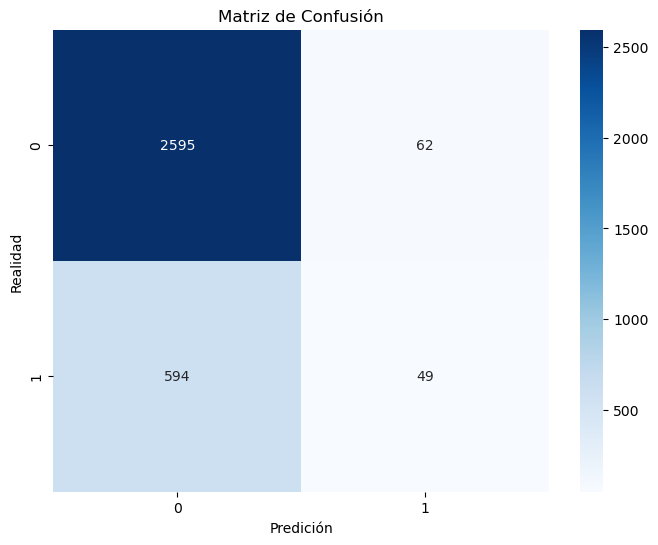

In [19]:
#matriz de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predición')
plt.ylabel('Realidad')
plt.show()

In [22]:
#Reporte de clasificación
print("Classification Report: \n", classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.98      0.89      2657
           1       0.44      0.08      0.13       643

    accuracy                           0.80      3300
   macro avg       0.63      0.53      0.51      3300
weighted avg       0.74      0.80      0.74      3300



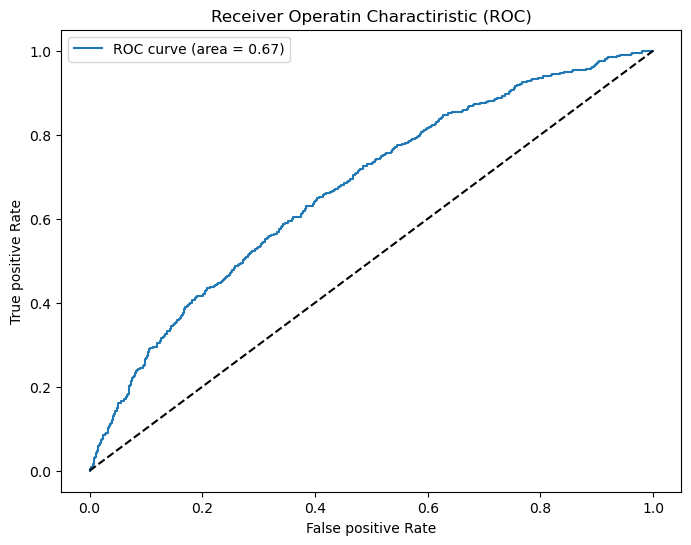

In [23]:
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

#Grafica curva ROC y AUC

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False positive Rate')
plt.ylabel('True positive Rate')
plt.title('Receiver Operatin Charactiristic (ROC)')
plt.legend(loc='best')
plt.show()

In [20]:
# Generar el binario del modelo para reutilizarlo, equivalencia de variables categoricas y caracteristicas del modelo
import pickle
pickle.dump(clf_lin, open("churn/models/model.pk", "wb"))
pickle.dump(column_equivalence, open("churn/models/column_equivalence.pk", "wb"))
pickle.dump(features, open("churn/models/features.pk", "wb"))